# Introduction

To Do in this section:
- **Project Motivation**: Briefly explain why ensemble methods are popular for regression, and the practical importance of comparing Bagging (RandomForest), Boosting (XGB), and Stacking.
- **Scope**: State that the notebook compares the three methods across six datasets of varying type (synthetic/real) and dimensionality.
- **Objective**: Clarify the goal: identify which method performs best in which context, and under what circumstances.



# Model and Data Import

In [1]:
from bagging_boosting_stacking_study.constants import (
    SEED,
    DATASET_NAMES,
    TRAINED_MODELS_PATH,
    ROOT_PATH
)
import os
from bagging_boosting_stacking_study.data.loaders import load_dataset
from bagging_boosting_stacking_study.models import load_model
from bagging_boosting_stacking_study.scripts.train_best_models import build_model
from pathlib import Path
import itertools
import math
import numpy as np
import pandas as pd
import plotly.io as pio
from sklearn.base import clone
from scipy.stats import wilcoxon, ttest_rel  # choose what you like
from sklearn.model_selection import KFold, train_test_split, learning_curve
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from IPython.display import display, Markdown
import joblib
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# dark theme across plots
# pio.templates.default = "plotly_dark"
# plt.style.use("dark_background")

## Reproducibility

- **Exploratory Data Analysis**  
  `notebooks/eda.ipynb`  

- **Preprocessing Pipeline**  
  `src/bagging_boosting_stacking_study/preprocessing.py`  

- **Model Training & Hyperparameter Search**  
  `notebooks/model_training.ipynb`  

> **Note:** A single global variable `SEED` is defined at the top of each notebook (and in `src/bagging_boosting_stacking_study/config.py`) and should be passed to every `random_state` or seed parameter to guarantee fully reproducible results.


# Evaluation Protocol

## Evaluation Scheme

In this notebook, model comparison is performed using a two-step evaluation protocol to ensure fair and rigorous assessment of model generalization.

### 1. K-Fold Cross-Validation (CV) on Training Data

- For each dataset, the training data (excluding the final test split) is used to evaluate model performance via K-Fold Cross-Validation.
- The **same splits and random seed** are used for all models to ensure direct comparability.
- During K-Fold CV, models are either retrained or their cross-validation scores (collected during hyperparameter tuning) are used to estimate performance.
- **Metrics computed:** For each fold and each model, RMSE, MAE, and R² are calculated. The mean and standard deviation across folds are reported.
- **Purpose:** This step estimates how well each model is expected to generalize to new data drawn from the same distribution as the training set and provides a basis for statistical comparison between models.

### 2. Out-of-Sample Test Set Evaluation

- After model selection and tuning (performed on the training/validation data), the **final, true comparison** is performed on the test set (10% holdout) that was **never seen during parameter tuning or training**.
- For each model, predictions are made on the test set using the pre-trained model.
- **Metrics computed:** RMSE, MAE, and R² are calculated for each model on the test set.
- **Purpose:** This evaluation provides an unbiased estimate of each model’s real-world performance and allows a direct comparison of their ability to generalize beyond the data used in hyperparameter tuning.

### Summary

- **K-Fold CV** scores enable robust statistical analysis and model ranking based on repeated sampling within the training data.
- **Test set evaluation** delivers a final, “realistic” performance measure, free from bias introduced by model selection and hyperparameter tuning.
- Both sets of results are reported for each model and dataset, and interpreted together for a comprehensive assessment.


# Main Results

## Summary Table of Metrics

**Goal:**  
To provide a clear, comprehensive overview of model performance across all datasets, using both KFold cross-validation and out-of-sample (test set) metrics, enabling quick visual comparison and identification of the best-performing models.

**To Do:**

1. **For Each Dataset:**
    - Prepare a table where each row is a model (Bagging, Boosting, Stacking).
    - For each model, include the following columns:
        - **KFold Metrics:**  
            - Mean and standard deviation (± std) of RMSE, MAE, and R² across folds.
        - **Test Set Metrics:**  
            - RMSE, MAE, and R², computed on the out-of-sample test set.
        - (Optional) Add a column for “Overfitting Gap”: difference between KFold mean and test set score for each metric.

2. **Table Structure Example:**

| Model    | RMSE (KFold) | MAE (KFold) | R² (KFold) | RMSE (Test) | MAE (Test) | R² (Test) | Overfitting Gap (RMSE) |
|----------|-------------|-------------|------------|-------------|------------|-----------|-----------------------|
| Bagging  | 1.23 ± 0.05 | 0.95 ± 0.03 | 0.89 ± 0.02| 1.29        | 1.01       | 0.88      | +0.06                 |
| Boosting | 1.19 ± 0.06 | 0.92 ± 0.04 | 0.91 ± 0.02| 1.21        | 0.96       | 0.90      | +0.02                 |
| Stacking | 1.15 ± 0.04 | 0.90 ± 0.03 | 0.92 ± 0.01| 1.14        | 0.89       | 0.92      | -0.01                 |

    - Repeat for each dataset.

3. **Highlight Best/Worst:**
    - Bold or color the best (lowest RMSE/MAE, highest R²) value in each column for easy identification.
    - Optionally, shade or annotate the worst value.

4. **Add Short Interpretation:**
    - After each table, include 1–2 sentences summarizing:
        - Which model performed best overall and by which metric.
        - Any notable observations (e.g., “Stacking had the highest R² and lowest RMSE on test for most datasets. Overfitting gap was smallest for boosting.”)

5. **(Optional) Aggregate Table:**
    - Create a master summary table showing for all datasets:
        - Which model had the best test RMSE, MAE, and R².
    - This can help reveal consistent winners across datasets.

---

**Summary:**  
This section provides a one-glance comparison of all models’ performance, supporting fast and informed discussion in subsequent analysis and synthesis sections.

## Statistical Comparison

**Goal:**  
To determine whether observed performance differences between models (e.g., bagging, boosting, stacking) are statistically significant, rather than due to random variation across folds.

**To Do:**

1. **Select Metrics and Model Pairs**
    - For each dataset and for each evaluation metric (RMSE, MAE, R²), compare the performance of all model pairs:
        - Bagging vs. Boosting
        - Bagging vs. Stacking
        - Boosting vs. Stacking

2. **Use Cross-Validation Scores**
    - Use the vector of K-Fold scores (one value per fold) for each model, per metric, per dataset.
    - These per-fold scores are necessary for paired statistical testing.

3. **Choose a Statistical Test**
    - If the distribution of score differences is approximately normal (rare, check if unsure): use the **paired t-test**.
    - Otherwise (default, more robust): use the **Wilcoxon signed-rank test** (non-parametric).
    - **Note:** Test the *null hypothesis* that the mean/median difference between model scores is zero.

4. **Perform the Tests**
    - For each model pair, metric, and dataset:
        - Compute the difference of scores per fold.
        - Run the chosen statistical test.
        - Record the test statistic and p-value.

5. **Report Results**
    - Create a table summarizing, for each dataset and metric:
        - Model pairs compared
        - Mean difference of scores
        - Test statistic
        - p-value (highlight statistically significant results, e.g. p < 0.05)
        - Optionally: 95% confidence interval of the difference

6. **Interpretation**
    - For each dataset and metric, briefly state:
        - Where differences are significant (e.g., “Stacking significantly outperforms Bagging on RMSE for California Housing, p=0.01”).
        - Where differences are not significant, note this too.

**Optional/Advanced:**
- If time allows, visualize the per-fold differences using boxplots or violin plots.
- Adjust for multiple comparisons (e.g., Bonferroni correction) if desired.

---

**Summary:**  
This section will determine which observed model performance differences are likely real and which coul

---
# Main Experiment
---

## Metrics

Below we list and briefly define each of the evaluation metrics we use throughout this notebook:

- **RMSE (Root Mean Squared Error)**  
  Measures the square root of the average squared differences between predicted and true values; penalizes larger errors more heavily.

- **MAE (Mean Absolute Error)**  
  Averages the absolute differences between predicted and true values; gives a more interpretable “average error” in the original units.

- **R² Score (Coefficient of Determination)**  
  Fraction of variance in the target explained by the model, ranges from –∞ to 1; higher is better (1 is perfect).


In [2]:
# Helper functions
def _kfold_scores(df, model_name: str, dataset_name: str, n_splits: int = 10):
    """Return per-fold arrays of RMSE / MAE / R2 for a single model."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    rmse, mae, r2 = [], [], []
    X_all = df.drop(columns="target")
    y_all = df["target"].values

    for train_idx, val_idx in kf.split(X_all):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        X_tr, y_tr = df_train.drop(columns="target"), df_train["target"].values
        X_va, y_va = df_val.drop(columns="target"), df_val["target"].values

        model = build_model(model_name, df_train, dataset_name)
        model.fit(X_tr, y_tr)

        y_hat = model.predict(X_va)
        rmse.append(np.sqrt(mean_squared_error(y_va, y_hat)))
        mae.append(mean_absolute_error(y_va, y_hat))
        r2.append(r2_score(y_va, y_hat))

    return np.array(rmse), np.array(mae), np.array(r2)


def _test_set_scores(df_train, df_test, model_name: str, dataset_name: str):
    """Return RMSE / MAE / R2 on the hold-out test set, loading a
    pre-trained model from disk if it exists (else refitting)."""
    model_path = Path(TRAINED_MODELS_PATH) / f"{dataset_name}_{model_name}.joblib"

    if model_path.exists():
        model = joblib.load(model_path)
    else:
        model = build_model(model_name, df_train, dataset_name)
        model.fit(df_train.drop(columns="target"), df_train["target"].values)

    X_test = df_test.drop(columns="target")
    y_test = df_test["target"].values
    y_hat = model.predict(X_test)

    return (
        np.sqrt(mean_squared_error(y_test, y_hat)),
        mean_absolute_error(y_test, y_hat),
        r2_score(y_test, y_hat),
    )


def _highlight_best(s, higher_is_better=False):
    """Styler helper: bold the best value in a column (handles 'mean ± std')."""
    # pull the mean part out of strings like "1.23 ± 0.04"
    vals = (
        s.str.split("±").str[0].astype(float) if s.dtype == object else s.astype(float)
    )
    best = vals.max() if higher_is_better else vals.min()
    return ["font-weight:bold" if v == best else "" for v in vals]

In [3]:
# High-level evaluation for one dataset
def evaluate_dataset(
    dataset_name: str,
    model_list: tuple = ("rf", "xgb", "stack"),
    k_splits: int = 10,
    compute_lc: bool = False,
    lc_fracs: np.ndarray = np.linspace(0.1, 1.0, 4),
):

    full_df = load_dataset(dataset_name=dataset_name, raw=False)
    df_train, df_test = train_test_split(full_df, test_size=0.1, random_state=SEED)

    rows, cv_bank = [], {}  # cv_bank stores per-fold scores for stats later
    lc_bank = {}  # learning curve bank
    feat_imp_records = []

    # pre-split for CV and LC if needed
    X_all = df_train.drop(columns="target")
    y_all = df_train["target"].values
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=SEED)

    for m in model_list:
        # K-Fold
        rmse_cv, mae_cv, r2_cv = _kfold_scores(df_train, m, dataset_name, k_splits)
        cv_bank[(m, "rmse")] = rmse_cv
        cv_bank[(m, "mae")] = mae_cv
        cv_bank[(m, "r2")] = r2_cv

        # Test set
        rmse_t, mae_t, r2_t = _test_set_scores(df_train, df_test, m, dataset_name)

        rows.append(
            dict(
                Model=m.capitalize(),
                RMSE_KFold=f"{rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}",
                MAE_KFold=f"{mae_cv.mean():.3f} ± {mae_cv.std():.3f}",
                R2_KFold=f"{r2_cv.mean():.3f} ± {r2_cv.std():.3f}",
                RMSE_Test=f"{rmse_t:.3f}",
                MAE_Test=f"{mae_t:.3f}",
                R2_Test=f"{r2_t:.3f}",
                OverfitGap_RMSE=f"{rmse_t - rmse_cv.mean():+.3f}",
            )
        )

    # Optional learning curve
    if compute_lc:
        # learning‐curve: train vs CV RMSE at fractions lc_fracs
        train_means, val_means = [], []
        for frac in lc_fracs:
            tr_rmses, va_rmses = [], []
            for tr_idx, va_idx in kf.split(X_all):
                # subset training fold
                n_sub = max(1, int(len(tr_idx) * frac))
                sub_idx = tr_idx[:n_sub]
                X_tr, y_tr = X_all.iloc[sub_idx], y_all[sub_idx]
                X_va, y_va = X_all.iloc[va_idx], y_all[va_idx]

                model = build_model(m, df_train, dataset_name)
                model.fit(X_tr, y_tr)
                tr_pred = model.predict(X_tr)
                va_pred = model.predict(X_va)

                tr_rmses.append(np.sqrt(mean_squared_error(y_tr, tr_pred)))
                va_rmses.append(np.sqrt(mean_squared_error(y_va, va_pred)))

            train_means.append(np.mean(tr_rmses))
            val_means.append(np.mean(va_rmses))

        lc_bank[m] = (lc_fracs, train_means, val_means)

    summary = pd.DataFrame(rows)

    feat_names = list(df_train.drop(columns="target").columns)
    for m in ["rf", "xgb"]:
        # Attempt to load pretrained pipeline; if not present, train one on df_train
        model_path = Path(TRAINED_MODELS_PATH) / f"{dataset_name}_{m}.joblib"
        if model_path.exists():
            pipeline = load_model(dataset_name=dataset_name, model_name=m)
        else:
            print(f"Something went wrong! The model wasn't loaded: {model_path}.")
            pipeline = build_model(m, df_train, dataset_name)
            pipeline.fit(X_all, y_all)

        # Extract feature_importances_ from final estimator
        try:
            final_est = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]
        except Exception:
            final_est = pipeline
        importances = final_est.feature_importances_

        # Collect into records
        for feat, imp in zip(feat_names, importances):
            feat_imp_records.append(
                {"Model": m.capitalize(), "feature": feat, "importance": imp}
            )

    # Build DataFrame of feature importances
    feat_imp_df = pd.DataFrame(feat_imp_records)

    styler = summary.style.apply(
        _highlight_best,
        subset=["RMSE_KFold", "MAE_KFold", "RMSE_Test", "MAE_Test", "OverfitGap_RMSE"],
    ).apply(_highlight_best, higher_is_better=True, subset=["R2_KFold", "R2_Test"])

    return summary, styler, cv_bank, lc_bank, feat_imp_df

In [4]:
# Paired statistical test (Wilcoxon by default)
def stat_tests(
    cv_bank, dataset_name: str, metrics=("rmse", "mae", "r2"), test_fn=wilcoxon
):

    records = []
    models = {key[0] for key in cv_bank}

    for metric in metrics:
        for m1, m2 in itertools.combinations(models, 2):
            x = cv_bank[(m1, metric)]
            y = cv_bank[(m2, metric)]

            # Direction: positive mean_diff → m1 > m2 (for r2); inverse for error metrics
            mean_diff = (x - y).mean()
            stat, p = test_fn(x - y)

            records.append(
                dict(
                    Dataset=dataset_name,
                    Metric=metric.upper(),
                    Model_A=m1.capitalize(),
                    Model_B=m2.capitalize(),
                    MeanDiff=mean_diff,
                    Stat=stat,
                    p_value=p,
                )
            )
    return pd.DataFrame(records)

In [5]:
# Configuration: Toggle saving of CSVs
SAVE_CSV = True  # Set to True to enable saving all outputs

# Directory to save results when SAVE_CSV is True
# output_dir = r"C:\Users\monik\OneDrive\Pulpit\ZUM\Projekt\bagging-boosting-stacking-study\results2"
output_dir = ROOT_PATH / "results"
if SAVE_CSV:
    os.makedirs(output_dir, exist_ok=True)

# Initialize containers for all results
DATASETS = [
    "regression",
    "energy_efficiency",
    "airfoil_self_noise",
    "friedman3",
    "friedman1",
    "california_hous",
]  # Replace with DATASET_NAMES for full evaluation
DATASETS = DATASET_NAMES
K_SPLITS = 10  # Use 10 for final evaluation

all_stats = []  # List of tuples: (dataset_name, stats_df)
summ_list = []  # List of tuples: (dataset_name, summary_df)
bank_list = []  # List of tuples: (dataset_name, flat_bank_df)
lc_list = []  # List of tuples: (dataset_name, learning_curve_data)
feat_imp_list = []  # List of tuples: (dataset_name, feature_importances_df)
model_winners = []  # List of dicts: {'Dataset': ..., 'Best_RMSE': ..., ...}

# MAIN LOOP: Evaluate each dataset and collect results
for ds in tqdm(DATASETS):
    # Run the evaluation (returns: summary_df, styled_summary, flat_bank_df, lc_bank, feat_imp_df)
    summ, sty, flat_bank, lc_bank, feat_imp_df = evaluate_dataset(
        ds,
        model_list = ("rf", "xgb", "stack"),
        k_splits=K_SPLITS,
        compute_lc=False,  # set to True if you want learning-curve data included
    )

    # Collect in-memory
    summ_list.append((ds, summ))
    bank_list.append((ds, flat_bank))
    lc_list.append((ds, lc_bank))
    feat_imp_list.append((ds, feat_imp_df))

    # Display in notebook (optional)
    display(Markdown(f"## {ds.replace('_',' ').title()} - {K_SPLITS}-Fold + Test"))
    display(sty)

    # Statistical tests on flat_bank
    stats_df = stat_tests(flat_bank, ds)
    all_stats.append((ds, stats_df))

    # Determine model winners based on test metrics in summary
    model_winners.append(
        {
            "Dataset": ds,
            "Best_RMSE": summ.loc[summ["RMSE_Test"].idxmin(), "Model"],
            "Best_MAE": summ.loc[summ["MAE_Test"].idxmin(), "Model"],
            "Best_R2": summ.loc[summ["R2_Test"].idxmax(), "Model"],
        }
    )

  0%|          | 0/6 [00:00<?, ?it/s]

## Regression - 10-Fold + Test

,Model,RMSE_KFold,MAE_KFold,R2_KFold,RMSE_Test,MAE_Test,R2_Test,OverfitGap_RMSE
0,Rf,58.621 ± 4.397,43.516 ± 2.988,0.882 ± 0.014,56.460,42.615,0.904,-2.160
1,Xgb,17.309 ± 2.794,12.813 ± 1.488,0.990 ± 0.003,15.124,12.134,0.993,-2.184
2,Stack,5.410 ± 0.595,4.122 ± 0.334,0.999 ± 0.000,4.612,3.665,0.999,-0.798


## Friedman1 - 10-Fold + Test

,Model,RMSE_KFold,MAE_KFold,R2_KFold,RMSE_Test,MAE_Test,R2_Test,OverfitGap_RMSE
0,Rf,0.811 ± 0.027,0.634 ± 0.020,0.972 ± 0.003,0.817,0.634,0.972,+0.006
1,Xgb,0.531 ± 0.015,0.420 ± 0.014,0.988 ± 0.001,0.515,0.410,0.989,-0.016
2,Stack,0.811 ± 0.027,0.634 ± 0.020,0.972 ± 0.003,0.817,0.634,0.972,+0.006


## Friedman3 - 10-Fold + Test

,Model,RMSE_KFold,MAE_KFold,R2_KFold,RMSE_Test,MAE_Test,R2_Test,OverfitGap_RMSE
0,Rf,0.313 ± 0.074,0.249 ± 0.053,0.402 ± 0.156,0.291,0.240,-0.307,-0.022
1,Xgb,0.305 ± 0.074,0.242 ± 0.057,0.433 ± 0.158,0.228,0.178,0.201,-0.077
2,Stack,0.314 ± 0.074,0.248 ± 0.053,0.387 ± 0.197,0.308,0.246,-0.460,-0.006


## California Housing - 10-Fold + Test

,Model,RMSE_KFold,MAE_KFold,R2_KFold,RMSE_Test,MAE_Test,R2_Test,OverfitGap_RMSE
0,Rf,0.597 ± 0.012,0.409 ± 0.007,0.734 ± 0.012,0.592,0.401,0.721,-0.005
1,Xgb,0.553 ± 0.014,0.381 ± 0.006,0.772 ± 0.014,0.550,0.375,0.759,-0.003
2,Stack,0.618 ± 0.012,0.424 ± 0.007,0.715 ± 0.012,0.615,0.419,0.698,-0.003


## Airfoil Self Noise - 10-Fold + Test

,Model,RMSE_KFold,MAE_KFold,R2_KFold,RMSE_Test,MAE_Test,R2_Test,OverfitGap_RMSE
0,Rf,1.555 ± 0.113,1.172 ± 0.070,0.942 ± 0.009,1.704,1.309,0.942,+0.149
1,Xgb,1.160 ± 0.133,0.800 ± 0.063,0.967 ± 0.009,1.271,0.861,0.968,+0.111
2,Stack,1.183 ± 0.118,0.833 ± 0.056,0.966 ± 0.008,1.326,0.936,0.965,+0.143


## Energy Efficiency - 10-Fold + Test

,Model,RMSE_KFold,MAE_KFold,R2_KFold,RMSE_Test,MAE_Test,R2_Test,OverfitGap_RMSE
0,Rf,0.453 ± 0.078,0.315 ± 0.047,0.998 ± 0.001,0.520,0.371,0.997,+0.068
1,Xgb,0.439 ± 0.069,0.314 ± 0.041,0.998 ± 0.001,0.522,0.378,0.997,+0.083
2,Stack,0.448 ± 0.081,0.317 ± 0.049,0.998 ± 0.001,0.522,0.384,0.997,+0.075


In [6]:
# Build full feature‐importance ranking DataFrame
records = []
for ds, feat_imp_df in feat_imp_list:
    # For each model within this dataset: sort and assign ranks
    for model in feat_imp_df["Model"].unique():
        df_m = feat_imp_df[feat_imp_df["Model"] == model].copy()
        df_m = df_m.sort_values("importance", ascending=False).reset_index(drop=True)
        df_m["Rank"] = np.arange(1, len(df_m) + 1)
        df_m["Dataset"] = ds
        records.append(df_m[["Dataset", "Model", "feature", "importance", "Rank"]])

feat_rank_df = pd.concat(records, ignore_index=True)

# Display the complete ranking table
display(
    feat_rank_df.sort_values(["Dataset", "Model", "Rank"])
    .style.format({"importance": "{:.4f}"})
    .set_caption("Full Feature-Importance Rankings")
)

,Dataset,Model,feature,importance,Rank
81,airfoil_self_noise,Rf,f,0.3403,1
82,airfoil_self_noise,Rf,f_delta,0.3365,2
83,airfoil_self_noise,Rf,delta_squared,0.0673,3
84,airfoil_self_noise,Rf,alpha_delta_pc1,0.0640,4
85,airfoil_self_noise,Rf,U_infinity,0.0588,5
86,airfoil_self_noise,Rf,c_0.1016,0.0343,6
87,airfoil_self_noise,Rf,c_0.0254,0.0324,7
88,airfoil_self_noise,Rf,alpha_squared,0.0291,8
89,airfoil_self_noise,Rf,c_0.0508,0.0140,9
90,airfoil_self_noise,Rf,c_0.1524,0.0105,10


In [7]:
# Master summary & Holm‐Bonferroni adjustment
agg_df = pd.DataFrame(model_winners)
display(agg_df.style.set_caption("Master Summary: Best Models by Metric"))

combined_stats = pd.concat(
    [stats_df.assign(Dataset=ds) for ds, stats_df in all_stats],
    ignore_index=True
)
adjusted = []
for (_, metric), grp in combined_stats.groupby(['Dataset','Metric']):
    rej, p_adj, _, _ = multipletests(grp['p_value'], method='holm')
    adjusted.append(grp.assign(p_adj=p_adj, Significant=rej))
combined_stats = pd.concat(adjusted, ignore_index=True)
display(
    combined_stats
      .sort_values(['Dataset','Metric','p_adj'])
      .style
      .format({'p_value':'{:.3f}','p_adj':'{:.3f}'})
      .set_caption("Statistical Tests (Holm-adjusted)")
)

,Dataset,Best_RMSE,Best_MAE,Best_R2
0,regression,Xgb,Xgb,Stack
1,friedman1,Xgb,Xgb,Xgb
2,friedman3,Xgb,Xgb,Xgb
3,california_housing,Xgb,Xgb,Xgb
4,airfoil_self_noise,Xgb,Xgb,Xgb
5,energy_efficiency,Rf,Rf,Rf


,Dataset,Metric,Model_A,Model_B,MeanDiff,Stat,p_value,p_adj,Significant
0,airfoil_self_noise,MAE,Rf,Stack,0.338784,0.000000,0.002,0.006,True
1,airfoil_self_noise,MAE,Rf,Xgb,0.371564,0.000000,0.002,0.006,True
2,airfoil_self_noise,MAE,Stack,Xgb,0.032780,1.000000,0.004,0.006,True
3,airfoil_self_noise,R2,Rf,Stack,-0.024166,0.000000,0.002,0.006,True
4,airfoil_self_noise,R2,Rf,Xgb,-0.025224,0.000000,0.002,0.006,True
5,airfoil_self_noise,R2,Stack,Xgb,-0.001058,17.000000,0.322,0.322,False
6,airfoil_self_noise,RMSE,Rf,Stack,0.371264,0.000000,0.002,0.006,True
7,airfoil_self_noise,RMSE,Rf,Xgb,0.394357,0.000000,0.002,0.006,True
8,airfoil_self_noise,RMSE,Stack,Xgb,0.023093,15.000000,0.232,0.232,False
9,california_housing,MAE,Rf,Stack,-0.015235,0.000000,0.002,0.006,True


In [8]:
# OPTIONAL CSV EXPORT
if SAVE_CSV:
    # Save per-dataset summary DataFrames
    for ds, summ in summ_list:
        summ_path = os.path.join(output_dir, f"{ds}_summary.csv")
        summ.to_csv(summ_path, index=False)
        print(f"Saved summary to: {summ_path}")

    # Save per-dataset flat_bank (could be DataFrame or dict)
    for ds, flat_bank in bank_list:
        if isinstance(flat_bank, dict):
            flat_bank_df = pd.DataFrame.from_dict(flat_bank)
        else:
            flat_bank_df = flat_bank

        bank_path = os.path.join(output_dir, f"{ds}_flat_bank.csv")
        flat_bank_df.to_csv(bank_path, index=False)
        print(f"Saved flat_bank to: {bank_path}")

    # Save per-dataset learning-curve data (if any; could be DataFrame or dict)
    # for ds, lc_bank in lc_list:
    #     if lc_bank is None:
    #         continue

    #     if isinstance(lc_bank, dict):
    #         for model_key, df_lc in lc_bank.items():
    #             if isinstance(df_lc, dict):
    #                 df_lc = pd.DataFrame.from_dict(df_lc)
    #             lc_path = os.path.join(output_dir, f"{ds}_learning_curve_{model_key}.csv")
    #             df_lc.to_csv(lc_path, index=False)
    #             print(f"Saved learning-curve ({model_key}) to: {lc_path}")
    #     else:
    #         lc_path = os.path.join(output_dir, f"{ds}_learning_curve.csv")
    #         lc_bank.to_csv(lc_path, index=False)
    #         print(f"Saved learning-curve to: {lc_path}")

    # Save per-dataset feature importances
    for ds, feat_imp_df in feat_imp_list:
        if feat_imp_df is None:
            continue
        if isinstance(feat_imp_df, dict):
            feat_imp_df = pd.DataFrame.from_dict(
                feat_imp_df, orient='index', columns=['Importance']
            ).reset_index().rename(columns={'index': 'Feature'})
        feat_imp_path = os.path.join(output_dir, f"{ds}_feature_importances.csv")
        feat_imp_df.to_csv(feat_imp_path, index=False)
        print(f"Saved feature importances to: {feat_imp_path}")

    # Save per-dataset statistical test results
    for ds, stats_df in all_stats:
        if isinstance(stats_df, dict):
            stats_df = pd.DataFrame.from_dict(stats_df)
        stats_path = os.path.join(output_dir, f"{ds}_stat_tests.csv")
        stats_df.to_csv(stats_path, index=False)
        print(f"Saved statistical tests to: {stats_path}")

    # Save master model winners
    if model_winners:
        winners_df = pd.DataFrame(model_winners)
        winners_path = os.path.join(output_dir, "model_winners.csv")
        winners_df.to_csv(winners_path, index=False)
        print(f"Saved model winners to: {winners_path}")

    # Save master aggregated statistical tests (concatenate all_stats)
    if all_stats:
        combined_stats = pd.concat(
            [df.assign(Dataset=ds) for ds, df in all_stats],
            ignore_index=True
        )
        combined_stats_path = os.path.join(output_dir, "all_stat_tests.csv")
        combined_stats.to_csv(combined_stats_path, index=False)
        print(f"Saved all statistical tests to: {combined_stats_path}")

    # Save feature importance ranking
    if 'feat_rank_df' in locals() and not feat_rank_df.empty:
        feat_rank_path = os.path.join(output_dir, "feature_rank.csv")
        feat_rank_df.to_csv(feat_rank_path, index=False)
        print(f"Saved feature importance ranking to: {feat_rank_path}")

print("CSV export completed." if SAVE_CSV else "CSV export is disabled (set SAVE_CSV = True to enable).")

Saved summary to: C:\code\repos\bagging-boosting-stacking-study\results\regression_summary.csv
Saved summary to: C:\code\repos\bagging-boosting-stacking-study\results\friedman1_summary.csv
Saved summary to: C:\code\repos\bagging-boosting-stacking-study\results\friedman3_summary.csv
Saved summary to: C:\code\repos\bagging-boosting-stacking-study\results\california_housing_summary.csv
Saved summary to: C:\code\repos\bagging-boosting-stacking-study\results\airfoil_self_noise_summary.csv
Saved summary to: C:\code\repos\bagging-boosting-stacking-study\results\energy_efficiency_summary.csv
Saved flat_bank to: C:\code\repos\bagging-boosting-stacking-study\results\regression_flat_bank.csv
Saved flat_bank to: C:\code\repos\bagging-boosting-stacking-study\results\friedman1_flat_bank.csv
Saved flat_bank to: C:\code\repos\bagging-boosting-stacking-study\results\friedman3_flat_bank.csv
Saved flat_bank to: C:\code\repos\bagging-boosting-stacking-study\results\california_housing_flat_bank.csv
Saved f

---
# Plots

In [9]:
# Compute grid dims for plots
n_datasets = len(DATASETS)
ncols = 3
nrows = math.ceil(n_datasets / ncols)

In [10]:
# fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)

# for idx, (ds, lc_bank) in enumerate(lc_list):
#     ax = axes[idx//ncols, idx % ncols]
#     # plot each model's train/val curve
#     for model_key, (fracs, train_rmse, val_rmse) in lc_bank.items():
#         ax.plot(fracs*100,
#                 train_rmse,
#                 marker='o',
#                 label=f"{model_key.capitalize()} Train")
#         ax.plot(fracs*100,
#                 val_rmse,
#                 linestyle='--',
#                 marker='s',
#                 label=f"{model_key.capitalize()} Val")
#     ax.set_title(ds.replace("_", " ").title())
#     ax.set_xlabel("Training Set Size (%)")
#     ax.set_ylabel("RMSE")
#     ax.grid(True)
#     ax.legend()

# # remove any unused subplots
# for j in range(idx+1, nrows*ncols):
#     fig.delaxes(axes[j//ncols, j % ncols])

# fig.tight_layout()
# plt.show()

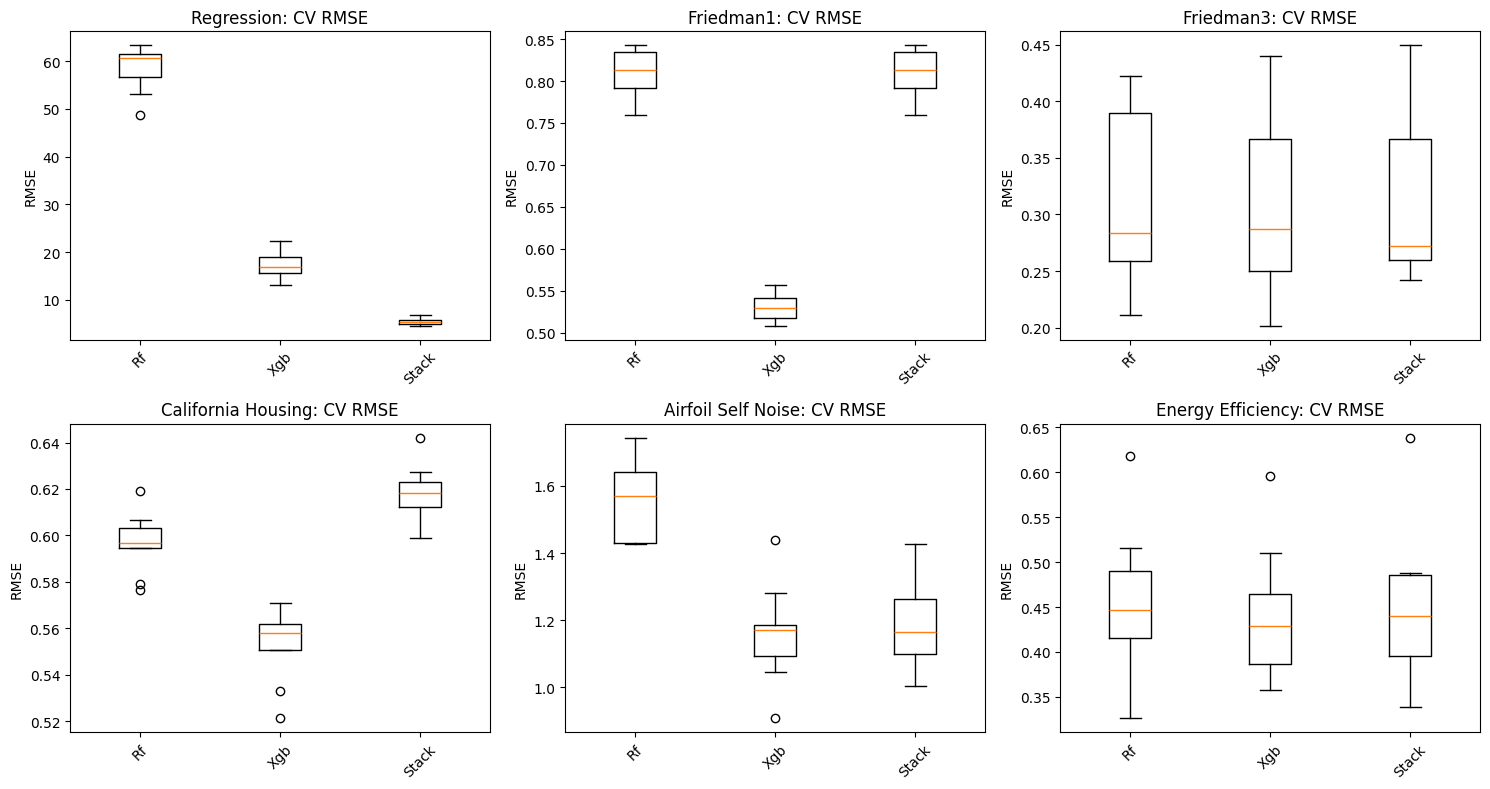

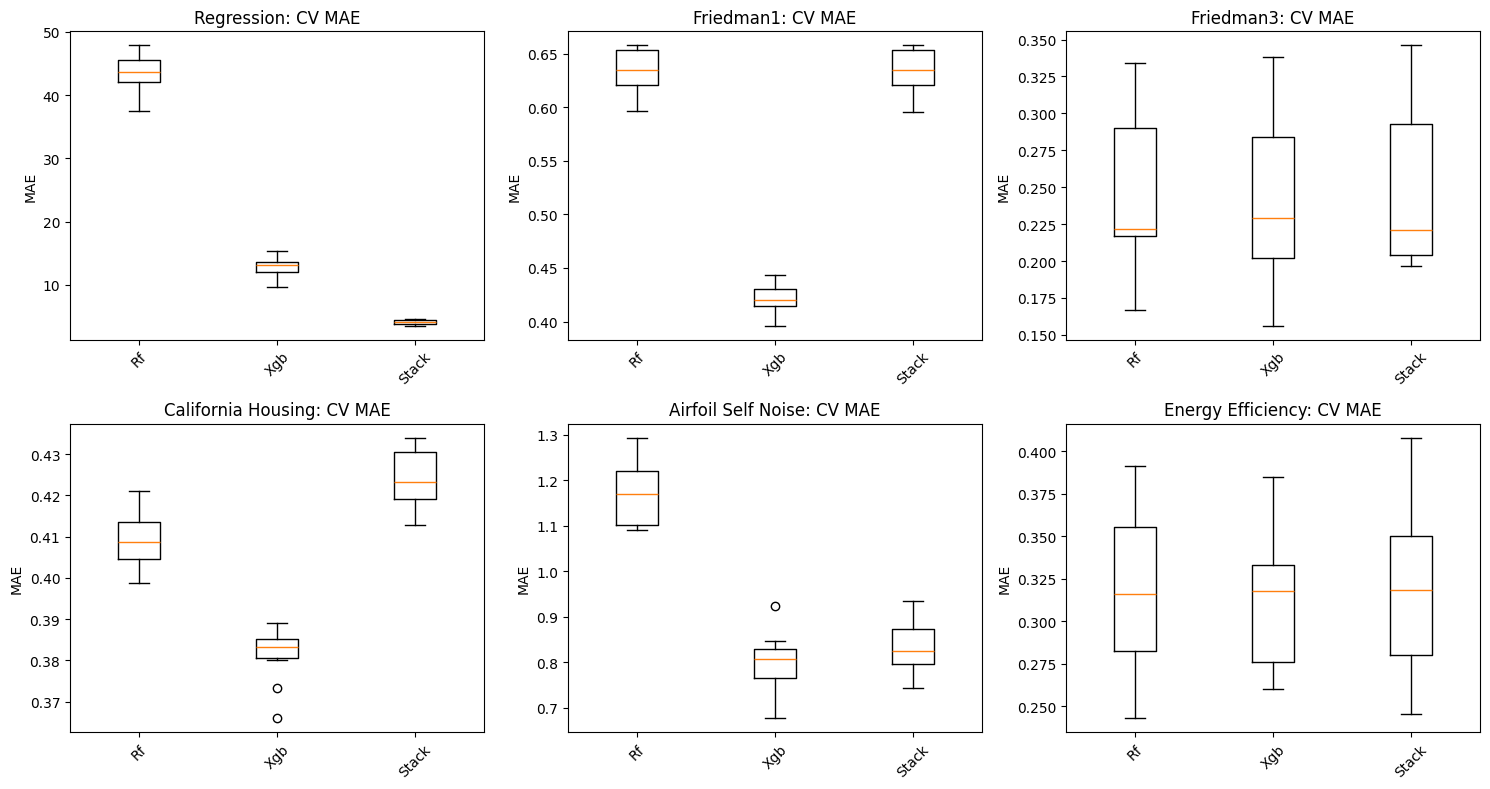

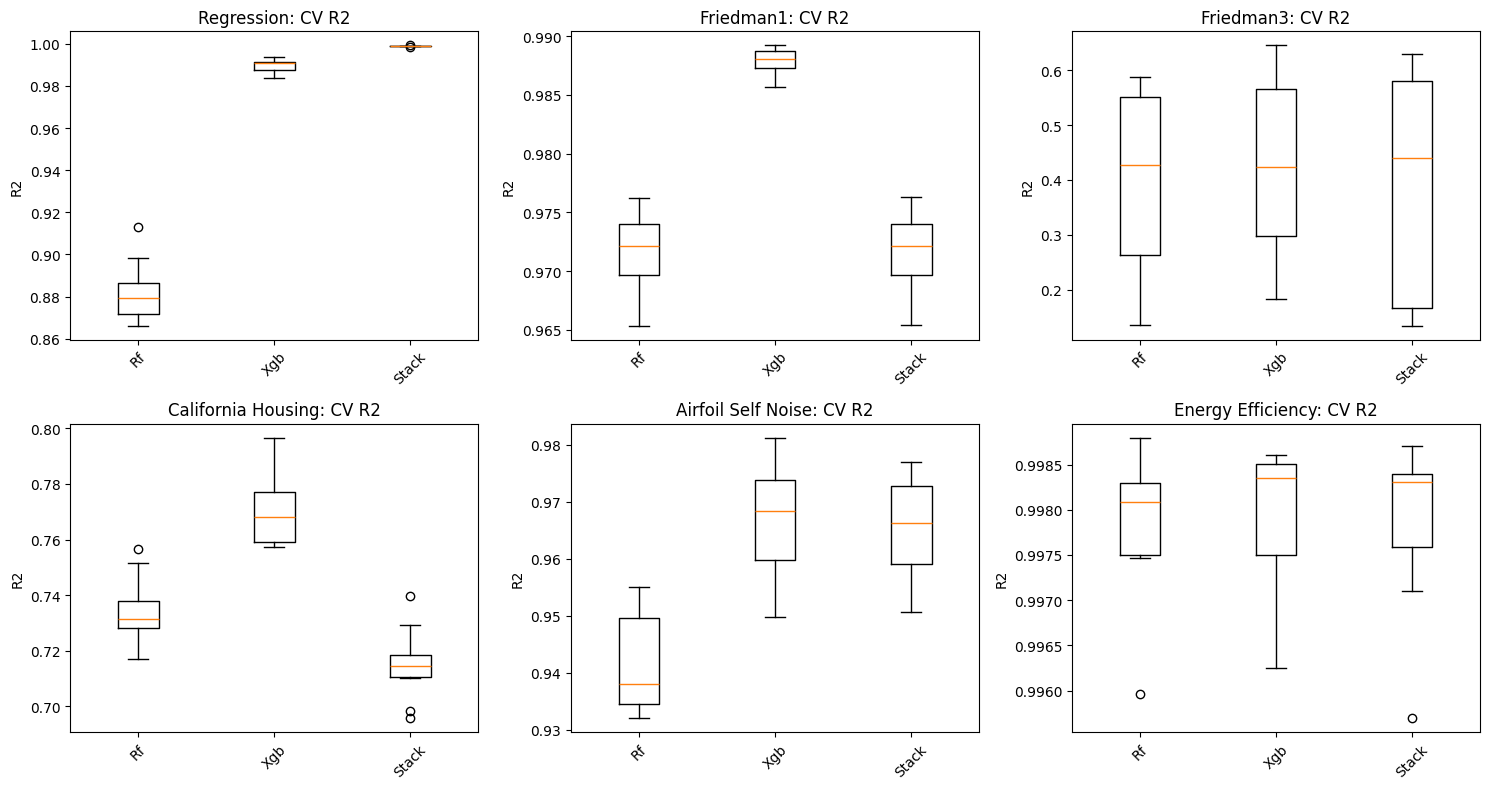

In [11]:
# CV‐Distribution Boxplots by Metric
metrics_cv = ["rmse", "mae", "r2"]
for metric in metrics_cv:
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)
    for idx, (ds, flat_bank) in enumerate(bank_list):
        ax = axes[idx//ncols, idx % ncols]
        model_keys = [m.lower() for m in summ_list[idx][1]["Model"]]
        data = [flat_bank[(key, metric)] for key in model_keys]
        ax.boxplot(data, tick_labels=[k.capitalize() for k in model_keys])
        ax.set_title(f"{ds.replace('_',' ').title()}: CV {metric.upper()}")
        ax.set_ylabel(metric.upper())
        ax.set_xticks(range(1, len(model_keys)+1))
        ax.set_xticklabels([k.capitalize() for k in model_keys], rotation=45)
    fig.tight_layout()
    plt.show()

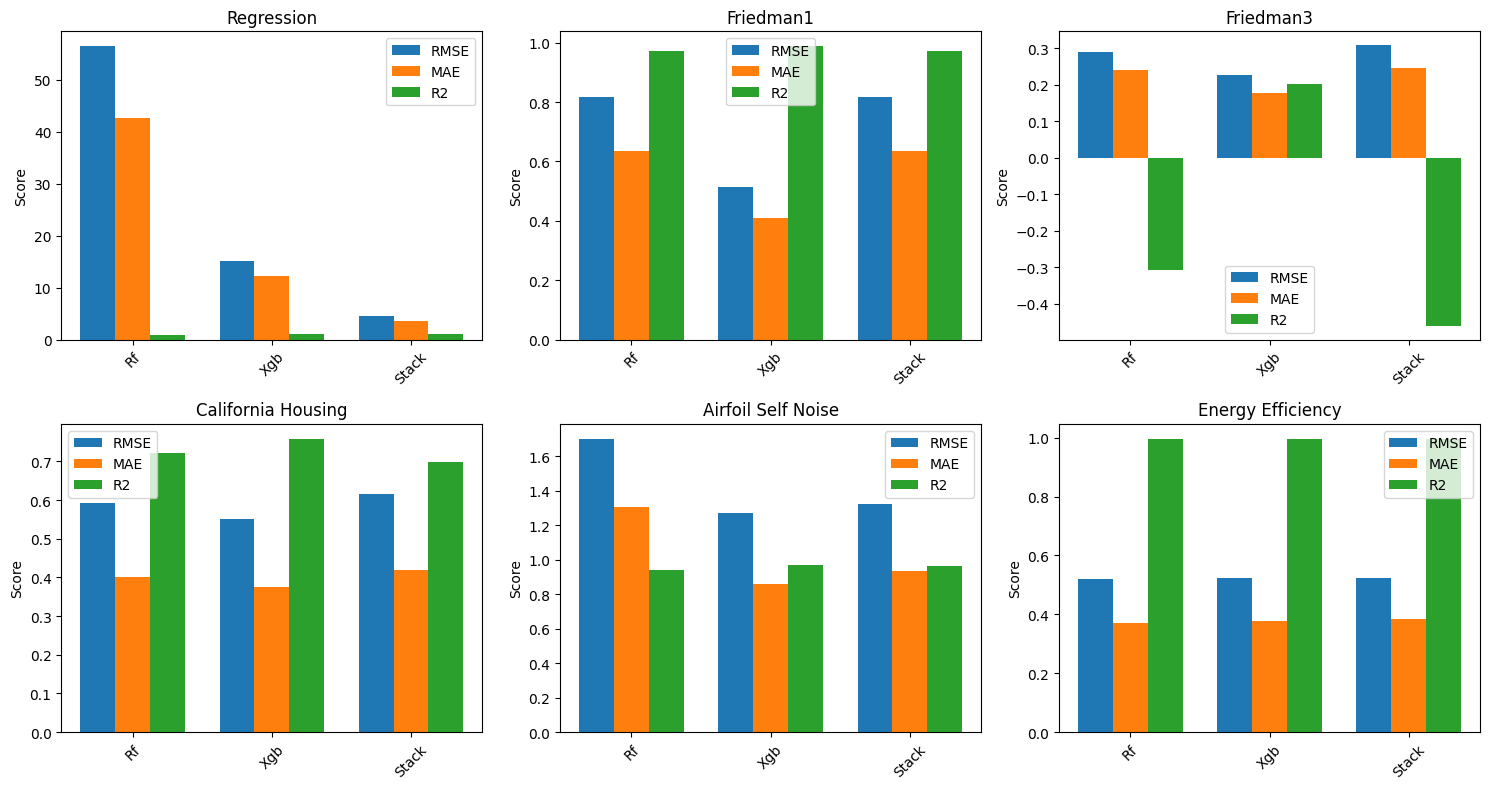

In [12]:
# Test‐Set Metrics by Model
metrics = ["RMSE_Test", "MAE_Test", "R2_Test"]
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)
for idx, (ds, summ) in enumerate(summ_list):
    ax = axes[idx//ncols, idx % ncols]
    models = summ["Model"]
    x = np.arange(len(models))
    width = 0.25
    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, summ[metric].astype(float), width,
               label=metric.replace("_Test",""))
    ax.set_title(ds.replace("_"," ").title())
    ax.set_xticks(x + width)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel("Score")
    ax.legend()
fig.tight_layout()
plt.show()

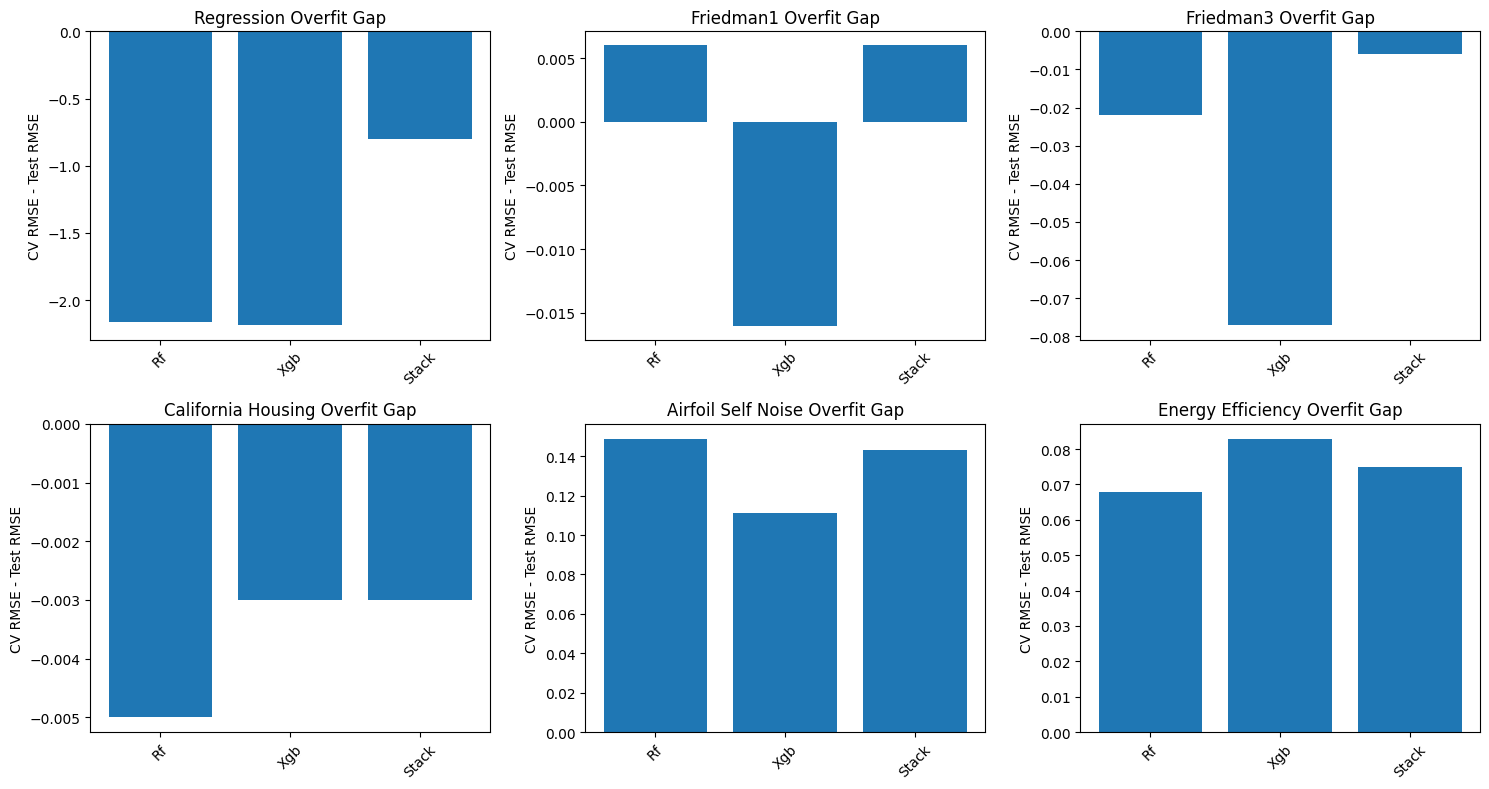

In [13]:
# Overfitting‐Gap per Model
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)
for idx, (ds, summ) in enumerate(summ_list):
    ax = axes[idx//ncols, idx % ncols]
    ax.bar(summ["Model"], summ["OverfitGap_RMSE"].astype(float))
    ax.set_title(f"{ds.replace('_',' ').title()} Overfit Gap")
    ax.set_ylabel("CV RMSE - Test RMSE")
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(summ["Model"], rotation=45)
fig.tight_layout()
plt.show()

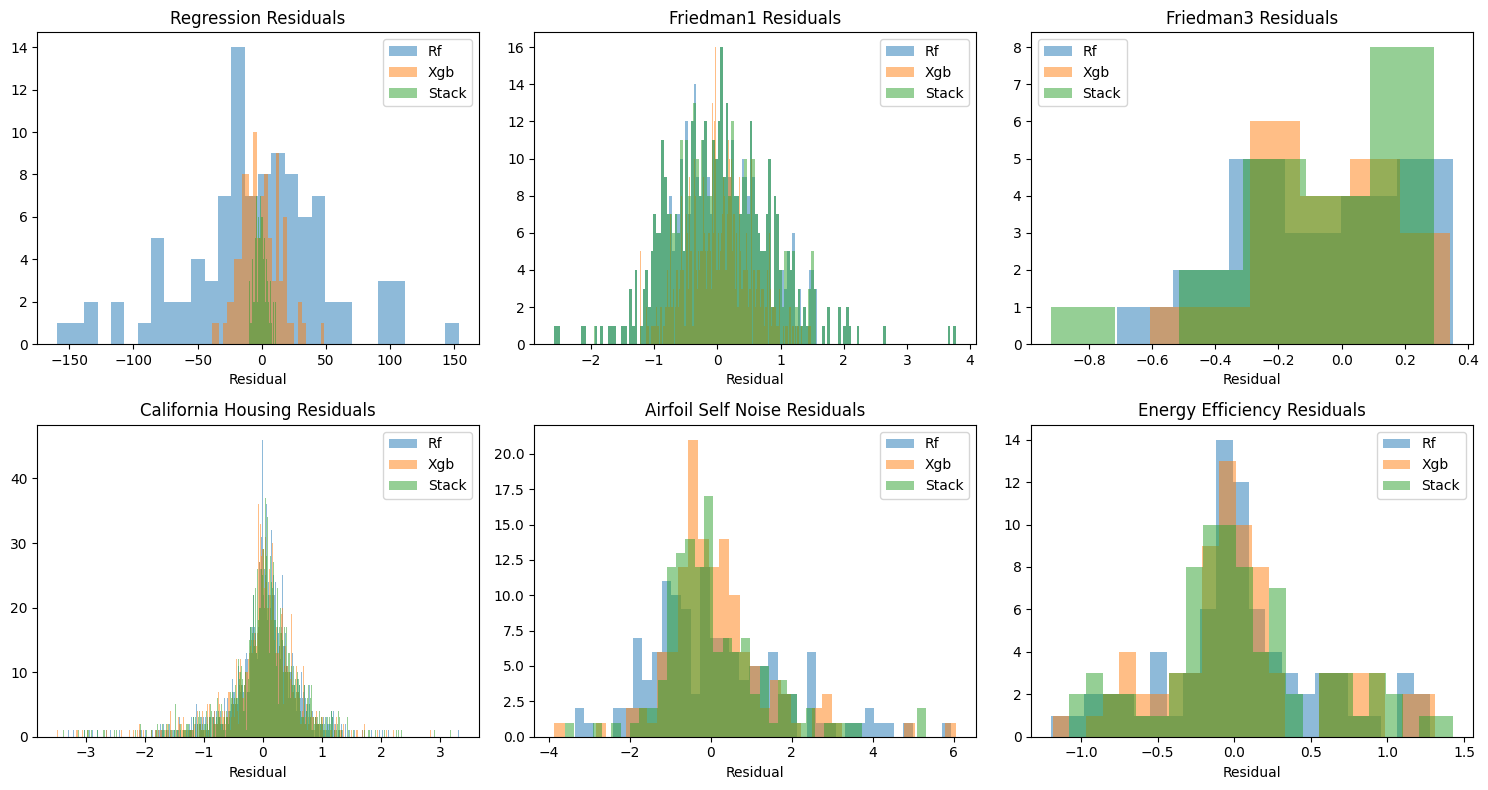

In [14]:
# Residuals Distributions
try:
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)
    for idx, (ds, _) in enumerate(summ_list):
        ax = axes[idx//ncols, idx % ncols]
        df = load_dataset(dataset_name=ds, raw=False)
        _, df_test = train_test_split(df, test_size=0.1, random_state=SEED)
        X_test = df_test.drop(columns="target"); y_test = df_test["target"].values
        model_keys = [m.lower() for m in summ_list[idx][1]["Model"]]
        for key in model_keys:
            model = load_model(dataset_name=ds, model_name=key)
            res = model.predict(X_test) - y_test
            # print(key)
            # print(X_test.shape[0])
            ax.hist(res, bins=int(X_test.shape[0] * 0.3), alpha=0.5, label=key.capitalize())
        ax.set_title(f"{ds.replace('_',' ').title()} Residuals")
        ax.set_xlabel("Residual")
        ax.legend()
    fig.tight_layout()
    plt.show()
except Exception as e:
    print(e)

## Automatic Interpretation of Best Models Across All Datasets

Below we loop over each `(dataset, summ)` pair collected in `summ_list`, display the dataset name, and report the best models for RMSE, MAE, R², and the smallest overfitting gap.


In [15]:
for ds, summ in summ_list:
    # Display a header for this dataset
    display(Markdown(f"### {ds.replace('_', ' ').title()}"))

    # Compute the best models
    best_rmse = summ.loc[summ['RMSE_Test'].idxmin(), 'Model']
    best_mae  = summ.loc[summ['MAE_Test'].idxmin(),  'Model']
    best_r2   = summ.loc[summ['R2_Test'].idxmax(),    'Model']
    best_gap  = summ.loc[summ['OverfitGap_RMSE'].idxmin(), 'Model']

    # Show the results
    display(Markdown(f"- **Lowest Test RMSE:** {best_rmse}"))
    display(Markdown(f"- **Lowest Test MAE:** {best_mae}"))
    display(Markdown(f"- **Highest Test R²:** {best_r2}"))
    display(Markdown(f"- **Smallest RMSE Overfit Gap:** {best_gap}"))

### Regression

- **Lowest Test RMSE:** Xgb

- **Lowest Test MAE:** Xgb

- **Highest Test R²:** Stack

- **Smallest RMSE Overfit Gap:** Stack

### Friedman1

- **Lowest Test RMSE:** Xgb

- **Lowest Test MAE:** Xgb

- **Highest Test R²:** Xgb

- **Smallest RMSE Overfit Gap:** Rf

### Friedman3

- **Lowest Test RMSE:** Xgb

- **Lowest Test MAE:** Xgb

- **Highest Test R²:** Xgb

- **Smallest RMSE Overfit Gap:** Stack

### California Housing

- **Lowest Test RMSE:** Xgb

- **Lowest Test MAE:** Xgb

- **Highest Test R²:** Xgb

- **Smallest RMSE Overfit Gap:** Xgb

### Airfoil Self Noise

- **Lowest Test RMSE:** Xgb

- **Lowest Test MAE:** Xgb

- **Highest Test R²:** Xgb

- **Smallest RMSE Overfit Gap:** Xgb

### Energy Efficiency

- **Lowest Test RMSE:** Rf

- **Lowest Test MAE:** Rf

- **Highest Test R²:** Rf

- **Smallest RMSE Overfit Gap:** Rf

---
# Additional Analyses
---

## Model Stability

Compute the **standard deviation** of the K-Fold RMSE, MAE, and R² for each model and dataset to assess stability. We’ll display a table of these values, then a grid of bar plots (one row per dataset, one column per metric).

,Dataset,Model,RMSE_STD,MAE_STD,R2_STD
12,airfoil_self_noise,Rf,0.119,0.074,0.009
13,airfoil_self_noise,Stack,0.125,0.059,0.009
14,airfoil_self_noise,Xgb,0.141,0.066,0.010
9,california_housing,Rf,0.012,0.007,0.013
10,california_housing,Stack,0.013,0.007,0.013
11,california_housing,Xgb,0.015,0.007,0.014
15,energy_efficiency,Rf,0.083,0.050,0.001
16,energy_efficiency,Stack,0.085,0.052,0.001
17,energy_efficiency,Xgb,0.073,0.043,0.001
3,friedman1,Rf,0.028,0.021,0.003


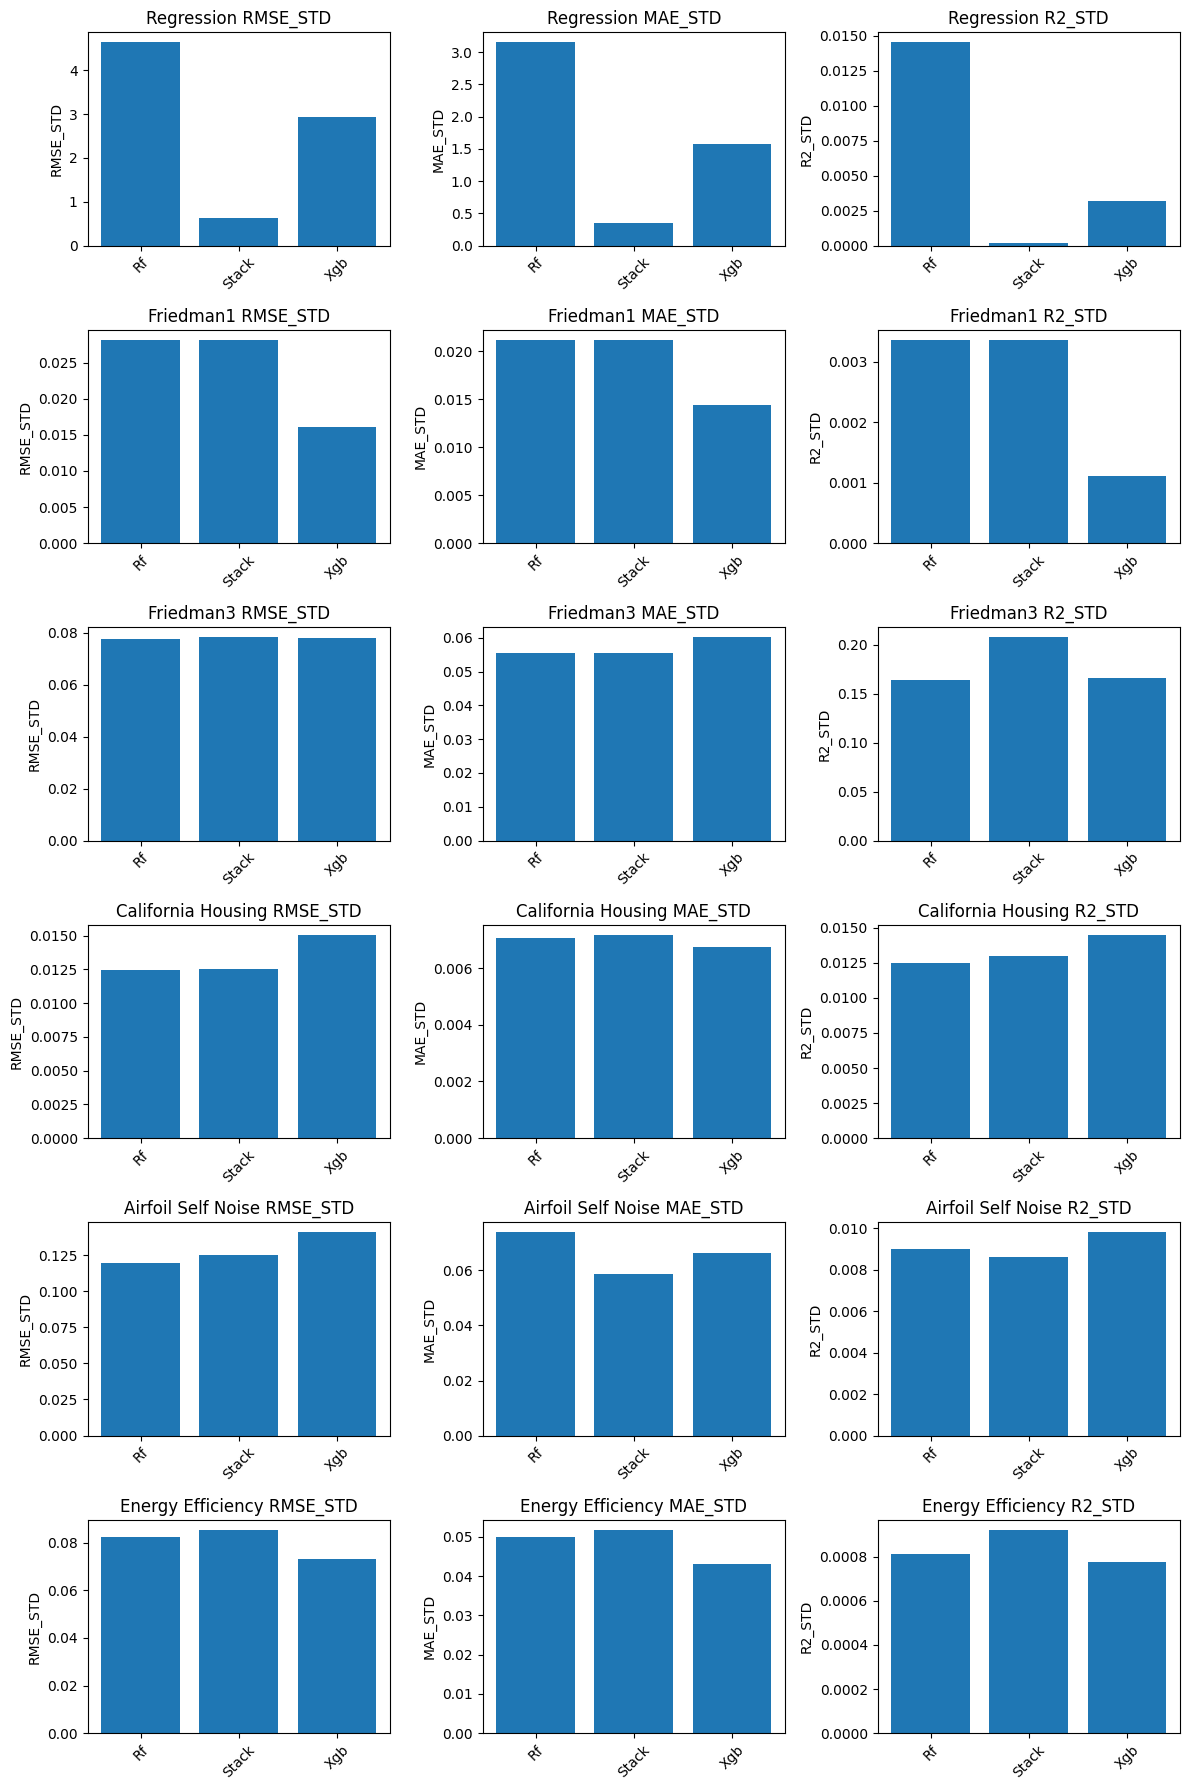

In [16]:
# Build a DataFrame of stability (std of CV folds)
records = []
for ds, flat_bank in bank_list:
    models = sorted({m for (m,_) in flat_bank.keys()})
    for m in models:
        records.append({
            'Dataset': ds,
            'Model': m.capitalize(),
            'RMSE_STD': np.std(flat_bank[(m,'rmse')], ddof=1),
            'MAE_STD' : np.std(flat_bank[(m,'mae')],  ddof=1),
            'R2_STD'  : np.std(flat_bank[(m,'r2')],   ddof=1),
        })
stability_df = pd.DataFrame(records).sort_values(['Dataset','Model'])

# Display table
display(
    stability_df
    .style
    .format({'RMSE_STD':'{:.3f}','MAE_STD':'{:.3f}','R2_STD':'{:.3f}'})
    .set_caption("Model Stability: Std of K-Fold Metrics")
)

# Bar-plot grid
metrics = ['RMSE_STD','MAE_STD','R2_STD']
n_datasets = len(DATASETS)
fig, axes = plt.subplots(n_datasets, len(metrics),
                         figsize=(len(metrics)*4, n_datasets*3),
                         squeeze=False)
for i, ds in enumerate(DATASETS):
    df_ds = stability_df[stability_df['Dataset']==ds]
    for j, metric in enumerate(metrics):
        ax = axes[i][j]
        ax.bar(df_ds['Model'], df_ds[metric])
        ax.set_title(f"{ds.replace('_',' ').title()} {metric}")
        ax.set_ylabel(metric)
        ax.set_xticks(range(len(df_ds)))
        ax.set_xticklabels(df_ds['Model'], rotation=45)
fig.tight_layout()
plt.show()


---
## Relative Performance Ranking

For each dataset and each Test‐set metric (RMSE, MAE, R²), we assign ranks (1 = best, 3 = worst). Lower RMSE/MAE is better, higher R² is better. This table makes it easy to see which model consistently wins.


In [17]:
# Collect per‐dataset rankings
records = []
for ds, summ in summ_list:
    df = summ.copy()
    # convert metric columns to float
    df["RMSE_Test"] = df["RMSE_Test"].astype(float)
    df["MAE_Test"]  = df["MAE_Test"].astype(float)
    df["R2_Test"]   = df["R2_Test"].astype(float)

    # rank: lower is better for RMSE/MAE, higher is better for R2
    df["Rank_RMSE"] = df["RMSE_Test"].rank(ascending=True,  method="dense").astype(int)
    df["Rank_MAE"]  = df["MAE_Test"].rank( ascending=True,  method="dense").astype(int)
    df["Rank_R2"]   = df["R2_Test"].rank(  ascending=False, method="dense").astype(int)

    for _, row in df.iterrows():
        records.append({
            "Dataset": ds,
            "Model": row["Model"],
            "RMSE_Rank": row["Rank_RMSE"],
            "MAE_Rank" : row["Rank_MAE"],
            "R2_Rank"  : row["Rank_R2"],
        })

ranking_df = pd.DataFrame(records).set_index(["Dataset","Model"])

# display as a table
display(
    ranking_df
    .sort_index()
    .style
    .format("{:.0f}")
    .set_caption("Relative Performance Ranking (1 = best)")
)


---
## Error Distribution & Residuals: Selected Datasets

For the first two datasets in `DATASETS_NAMES` (or 'DATASETS'), we plot histograms of the out-of-sample residuals (predicted − true) for each model. This highlights bias and tail behavior.


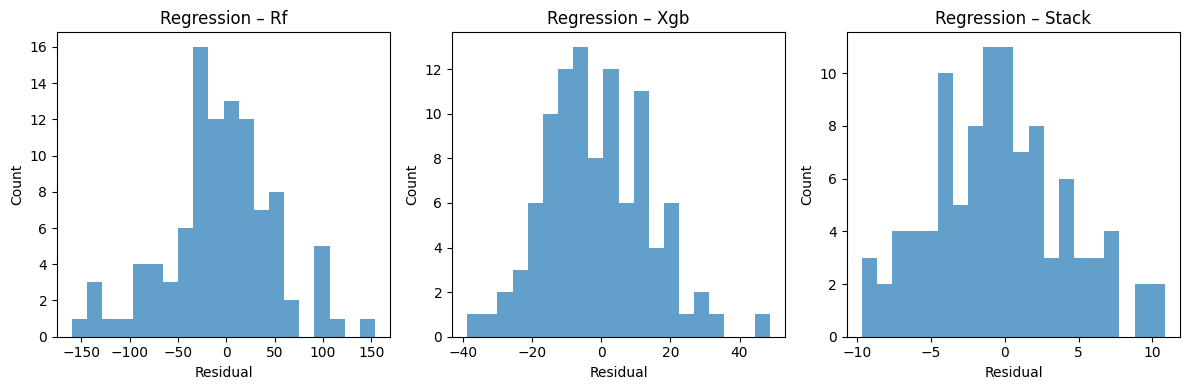

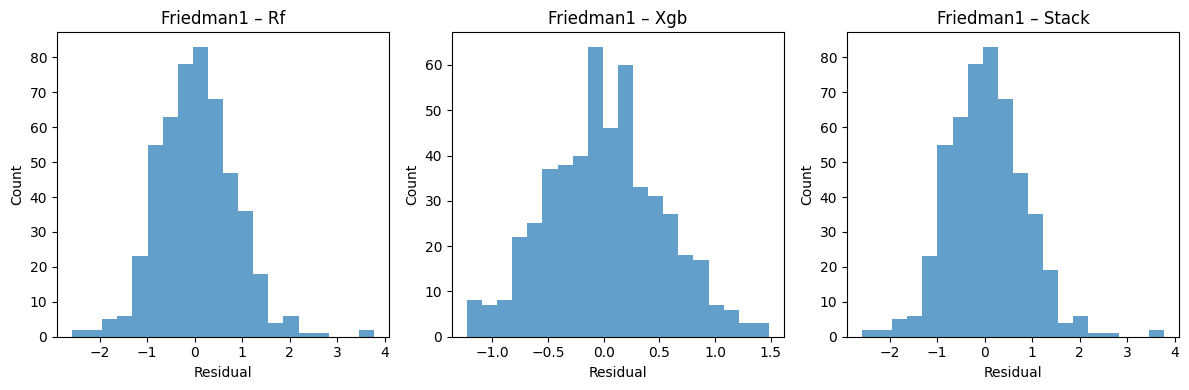

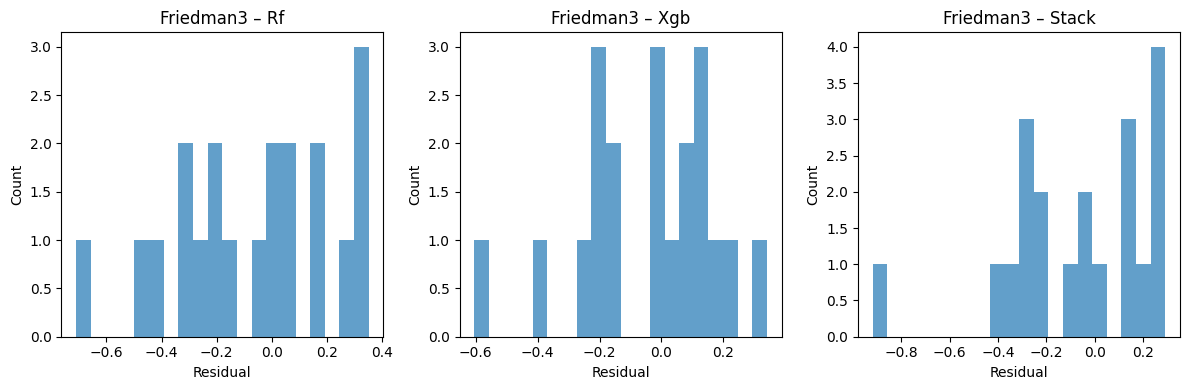

In [18]:
# Select first two datasets
selected = summ_list[:3]

for ds, summ in selected:
    # load and split data
    df = load_dataset(dataset_name=ds, raw=False)
    _, df_test = train_test_split(df, test_size=0.1, random_state=SEED)
    X_test = df_test.drop(columns="target")
    y_test = df_test["target"].values

    # model keys
    model_keys = [m.lower() for m in summ["Model"]]

    # set up grid: one row per dataset, one column per model
    n_models = len(model_keys)
    fig, axes = plt.subplots(1, n_models, figsize=(4*n_models, 4), squeeze=False)
    for j, key in enumerate(model_keys):
        ax = axes[0, j]
        # load pretrained model and compute residuals
        model = load_model(dataset_name=ds, model_name=key)
        res = model.predict(X_test) - y_test
        ax.hist(res, bins=20, alpha=0.7)
        ax.set_title(f"{ds.replace('_',' ').title()} – {key.capitalize()}")
        ax.set_xlabel("Residual")
        ax.set_ylabel("Count")
    fig.tight_layout()
    plt.show()

## True vs. Predicted Scatter Plots: Selected Datasets

For the same two datasets, plot true target vs. predicted target for each model on the hold‐out test set. This reveals bias and systematic deviations.

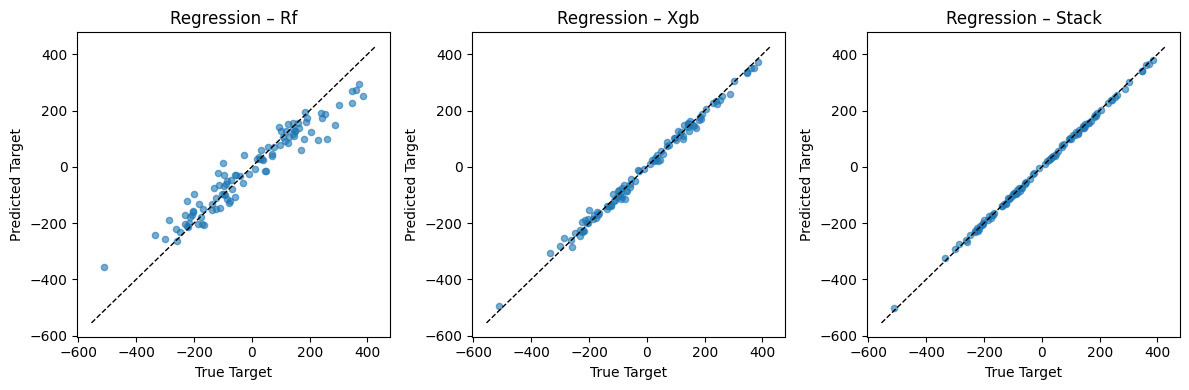

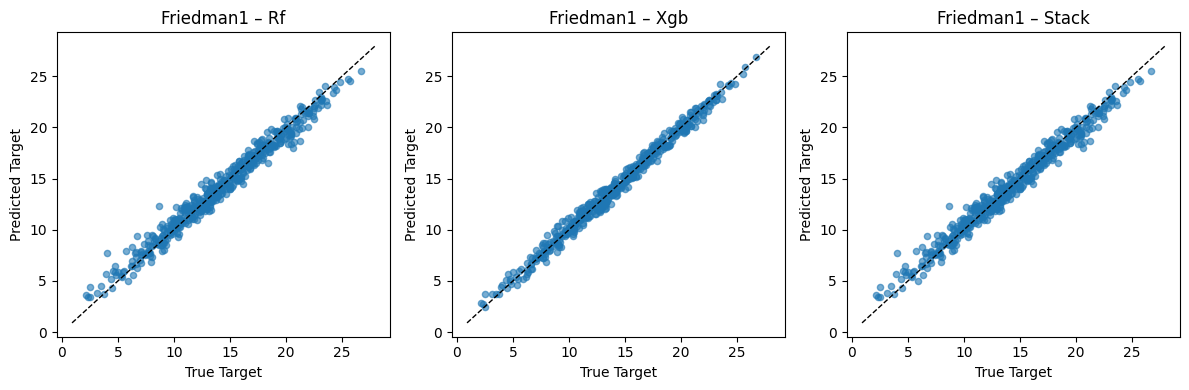

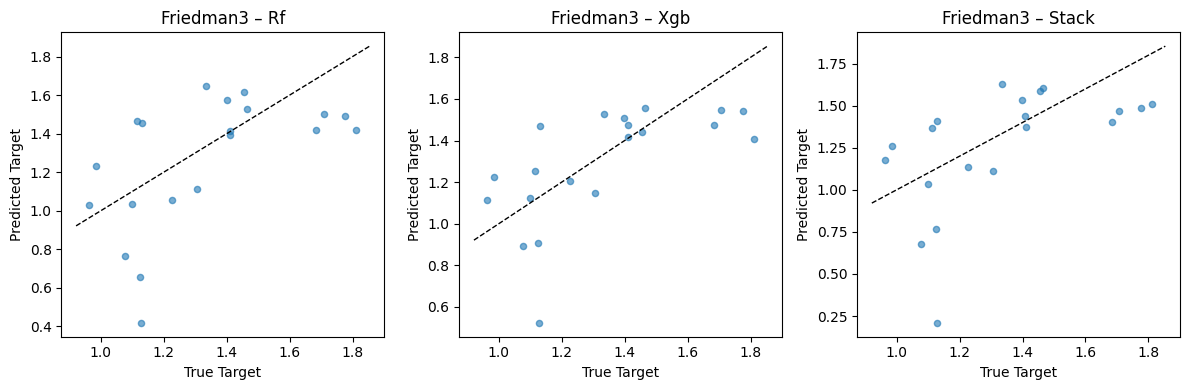

In [19]:
for ds, summ in selected:
    df = load_dataset(dataset_name=ds, raw=False)
    _, df_test = train_test_split(df, test_size=0.1, random_state=SEED)
    X_test = df_test.drop(columns="target")
    y_test = df_test["target"].values

    model_keys = [m.lower() for m in summ["Model"]]
    n_models = len(model_keys)
    fig, axes = plt.subplots(1, n_models, figsize=(4*n_models, 4), squeeze=False)
    for j, key in enumerate(model_keys):
        ax = axes[0, j]
        model = load_model(dataset_name=ds, model_name=key)
        y_pred = model.predict(X_test)
        ax.scatter(y_test, y_pred, alpha=0.6, s=20)
        # diagonal line
        mn, mx = ax.get_xlim()
        ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1)
        ax.set_title(f"{ds.replace('_',' ').title()} – {key.capitalize()}")
        ax.set_xlabel("True Target")
        ax.set_ylabel("Predicted Target")
    fig.tight_layout()
    plt.show()

---
## Overfitting Check: Test vs CV RMSE Gap

For each dataset and model, we compute the “overfitting gap” as:


Gap = Test RMSE - Mean CV RMSE


A positive gap means the model performed worse on the hold-out set than on cross-validation (a sign of overfitting). We’ll show:

1. A **pivot table** of gaps.  
2. A **grid of bar plots** (one subplot per dataset).

Model,Rf,Stack,Xgb
Dataset,,,
airfoil_self_noise,0.149,0.143,0.111
california_housing,-0.005,-0.003,-0.003
energy_efficiency,0.067,0.074,0.083
friedman1,0.006,0.006,-0.016
friedman3,-0.022,-0.006,-0.077
regression,-2.161,-0.798,-2.185


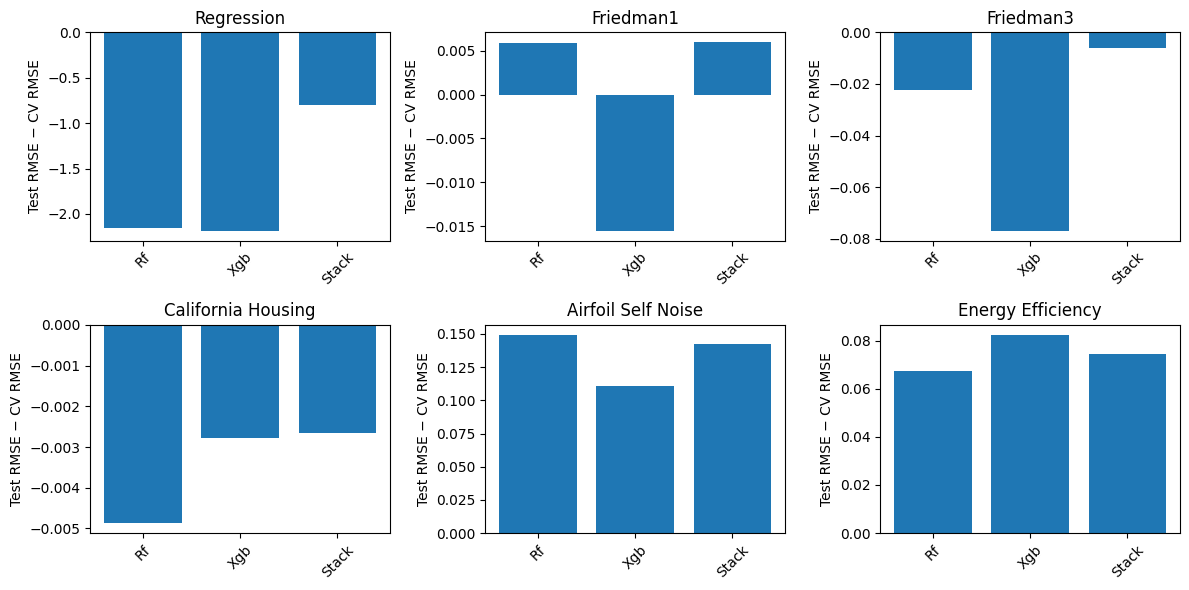

In [20]:
# Compute gaps
records = []
for (ds, flat_bank), (_, summ) in zip(bank_list, summ_list):
    for key in [m.lower() for m in summ["Model"]]:
        cv_mean   = flat_bank[(key, "rmse")].mean()
        ser = summ.loc[summ["Model"].str.lower() == key, "RMSE_Test"]
        test_rmse = float(ser.iloc[0])
        records.append({
            "Dataset": ds,
            "Model": key.capitalize(),
            "Overfit_Gap_RMSE": test_rmse - cv_mean
        })
gap_df = pd.DataFrame(records)

# Pivot table display
pivot = gap_df.pivot(index="Dataset", columns="Model", values="Overfit_Gap_RMSE")
display(
    pivot.style
         .format("{:.3f}")
         .set_caption("Overfitting Gap (Test RMSE − Mean CV RMSE)")
)

# Bar‐plot grid with explicit ticks
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), squeeze=False)

for idx, ds in enumerate(DATASETS):
    ax = axes[idx // ncols, idx % ncols]
    df_ds = gap_df[gap_df["Dataset"] == ds]
    
    models = df_ds["Model"].tolist()
    gaps   = df_ds["Overfit_Gap_RMSE"].values
    x = np.arange(len(models))
    
    ax.bar(x, gaps)
    ax.set_title(ds.replace("_", " ").title())
    ax.set_ylabel("Test RMSE − CV RMSE")
    
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)

fig.tight_layout()
plt.show()

---
## Feature importance

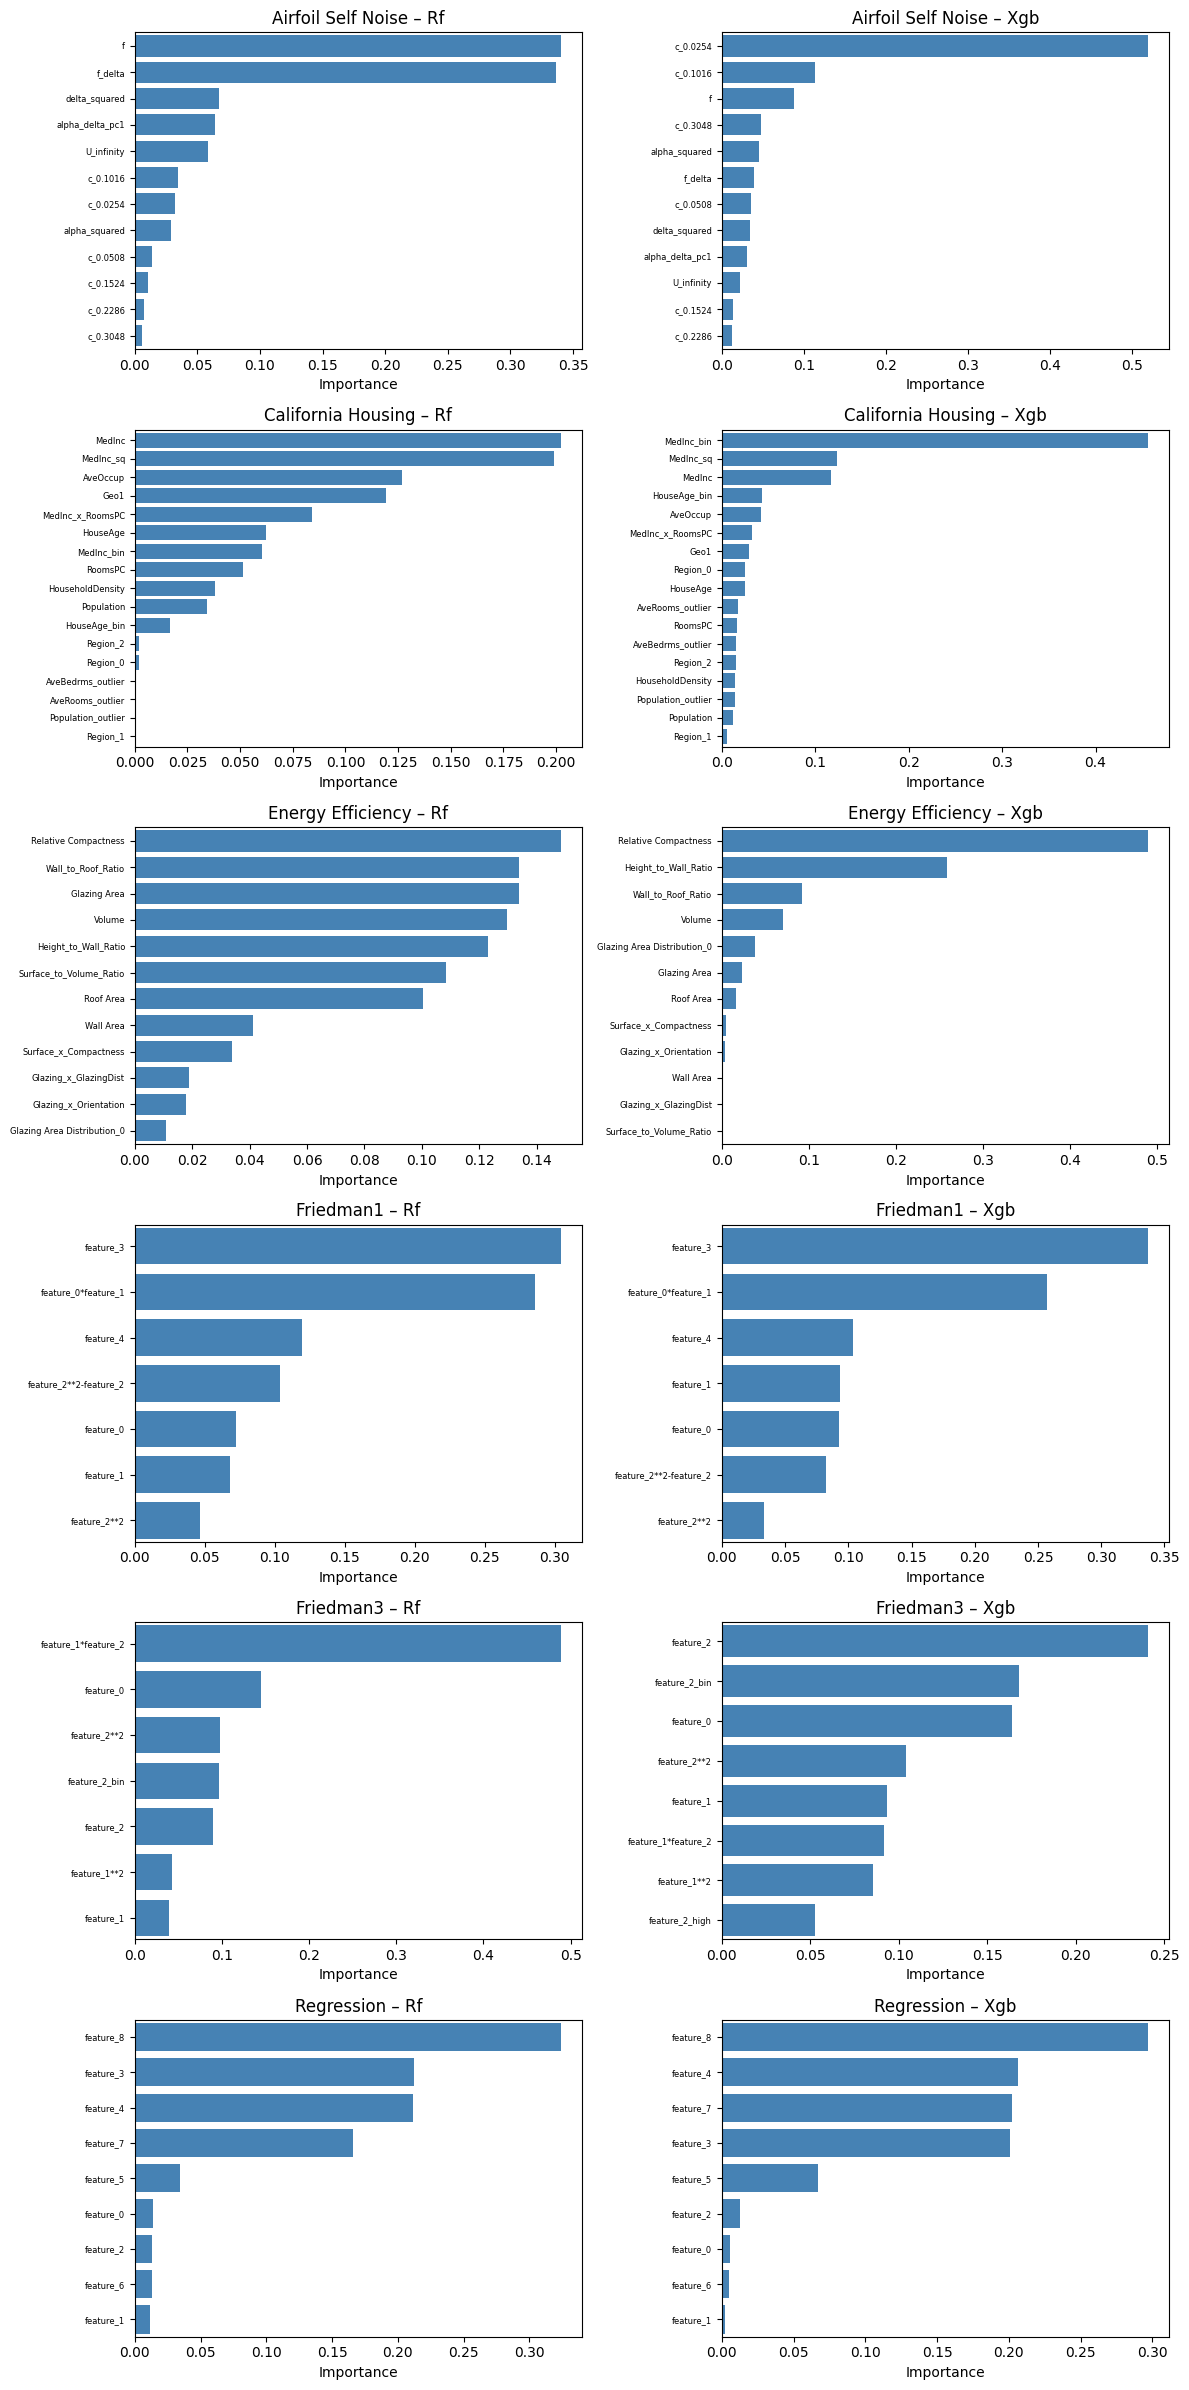

In [21]:
# Determine unique datasets and models
datasets = sorted(feat_rank_df["Dataset"].unique())
models = sorted(feat_rank_df["Model"].unique())

nrows = len(datasets)
ncols = len(models)

# Create a grid of subplots: one row per dataset, one column per model
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 6, nrows * 4),
    squeeze=False
)

for i, ds in enumerate(datasets):
    for j, m in enumerate(models):
        ax = axes[i][j]
        # Filter for this dataset & model, sort by importance ascending (for horizontal bar)
        df_sub = feat_rank_df[
            (feat_rank_df["Dataset"] == ds) &
            (feat_rank_df["Model"] == m)
        ].sort_values("importance", ascending=True)

        # Horizontal bar plot: feature names on y-axis, importance on x-axis
        ax.barh(df_sub["feature"], df_sub["importance"], color="steelblue")
        ax.set_title(f"{ds.replace('_',' ').title()} – {m}")
        ax.set_xlabel("Importance")
        ax.set_ylabel("")

        # Reduce y‐tick label font size for readability if many features
        ax.tick_params(axis="y", labelsize=6)

        # Optionally, tighten y-axis margins
        ax.margins(y=0.01)

# Tight layout for the entire figure
fig.tight_layout()
plt.show()

# Summary and Conclusion

### Key Results Table
Instruction: Create a summary table with best out-of-sample metric per model/dataset (and highlight the “winner”).

Tip: Makes the main takeaways instantly clear.

###  Dataset-by-Dataset Takeaways
Instruction: For each dataset, write 1–2 bullets:

Which model won, how big was the difference, and any interesting observations (e.g., "Stacking wins on high-dim synthetic, XGB on real-world, differences are small on [dataset]").

Tip: Speculate on possible reasons (e.g., noise, nonlinearity, sample size).

###  General Insights
Instruction: Write a short narrative summarizing patterns across datasets and models:

When does each method tend to win?

Are some models more robust? Do some overfit more?

Any practical tradeoffs (e.g., computation, interpretability)?

### Conclusion

Instruction: Wrap up main lessons from the benchmark.

Instruction: Discuss limitations (e.g., only three ensemble types, only regression).

Instruction: Suggest potential future work (e.g., classification, deeper stacking ablation, more diverse datasets).